In [1]:
import os
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("✓ TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings")

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

print("✓ Configuración de warnings completada")

✓ TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings
✓ Configuración de warnings completada


# Modelado de Tópicos con FASTopic

Este notebook implementa un análisis de tópicos usando FASTopic sobre las opiniones turísticas clasificadas. Utiliza LangChain con GPT-4o-mini para asignar nombres semánticamente coherentes a los tópicos identificados y compara resultados con BERTopic.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
from dotenv import load_dotenv

sys.path.append('../scripts')

from topicos import (
    configurar_clasificador_topicos, 
    configurar_fastopic_inteligente,
    LimpiadorTextoMejorado, 
    mostrar_ejemplos_limpieza,
    evaluar_modelo_topicos,
    extraer_palabras_fastopic,
    mostrar_metricas
)

from topicos.utils_topicos import (
    procesar_topicos_fastopic,
    obtener_asignaciones_topicos_fastopic,
    visualizar_distribucion_topicos_fastopic,
    mostrar_ejemplos_por_topico_fastopic,
    generar_reporte_fastopic
)

load_dotenv()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

✓ Modelo spaCy español cargado
✓ Modelo spaCy inglés cargado
✓ Modelo spaCy inglés cargado
✓ Modelo spaCy portugués cargado
✓ Modelo spaCy portugués cargado
✓ Modelo spaCy francés cargado
✓ Modelo spaCy francés cargado
✓ Modelo spaCy italiano cargado
Descargando wordnet...
✓ Modelo spaCy italiano cargado
Descargando wordnet...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
clasificador_topicos = configurar_clasificador_topicos()

In [4]:
CIUDAD_ANALIZAR = "Cdmx"
df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

if 'TopicoConFASTopic' not in df.columns:
    df['TopicoConFASTopic'] = np.nan

print(f"Dataset cargado: {df.shape[0]} opiniones")
print(f"Distribución total por ciudad:")
print(df['Ciudad'].value_counts())

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()

columna_texto = 'TituloReviewLimpio'

texts = df_ciudad[columna_texto].dropna().tolist()

Dataset cargado: 2464 opiniones
Distribución total por ciudad:
Ciudad
Puebla             500
Mazatlan           500
Puerto_vallarta    491
Cdmx               490
Cancun             483
Name: count, dtype: int64


In [5]:
columna_limpia = "TituloReviewLimpio"

limpiar_de_nuevo = False

if columna_limpia not in df.columns or limpiar_de_nuevo:
    limpiador = LimpiadorTextoMejorado(idiomas=['spanish', 'english'])
    
    df = limpiador.limpiar_dataframe(
        df,
        columna_texto='TituloReview',
        nombre_columna_limpia=columna_limpia,
        aplicar_traduccion=True,
        filtrar_adjetivos=True,  # Nueva opción para filtrar adjetivos
        aplicar_lematizacion=True,
        min_longitud_palabra=2,
        max_palabras=None
    )
    
    df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()
texts = df_ciudad[columna_texto].dropna().tolist()

In [6]:
topic_model, reporte_optimizacion = configurar_fastopic_inteligente(texts)
    
print("🤖 Configuración automática de FASTopic completada")
print(reporte_optimizacion)

2025-09-22 16:13:54,966 - FASTopic - use device: cpu


🤖 Configuración automática de FASTopic completada

📊 CONFIGURACIÓN AUTOMÁTICA DE FASTOPIC

📈 Análisis del Corpus:
  📄 Documentos: 490
  📝 Palabras promedio por doc: 53.1
  🔤 Vocabulario único: 2,415

🎯 Configuración:
  🏷️ Número de tópicos: 7
  📚 Tamaño vocabulario: 2,415
  🌍 Modelo embeddings: paraphrase-multilingual-MiniLM-L12-v2
  🔧 Tokenizer: Multiidioma (ES, EN, PT, FR, IT)



In [7]:
print("\n🚀 Entrenando modelo FASTopic...")
inicio_entrenamiento = time.time()

top_words, doc_topic_dist = topic_model.fit_transform(texts, epochs=200)

tiempo_entrenamiento = time.time() - inicio_entrenamiento
print(f"✅ Entrenamiento completado en {tiempo_entrenamiento:.2f} segundos")

2025-09-22 16:13:54,983 - FASTopic - First fit the model.



🚀 Entrenando modelo FASTopic...


parsing texts: 100%|██████████| 490/490 [00:07<00:00, 66.59it/s]
2025-09-22 16:14:13,651 - TopMost - Real vocab size: 477
2025-09-22 16:14:13,652 - TopMost - Real training size: 490 	 avg length: 14.951
parsing texts: 100%|██████████| 490/490 [00:07<00:00, 66.59it/s]
2025-09-22 16:14:13,651 - TopMost - Real vocab size: 477
2025-09-22 16:14:13,652 - TopMost - Real training size: 490 	 avg length: 14.951


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Training FASTopic:   9%|▉         | 18/200 [00:00<00:05, 30.80it/s]2025-09-22 16:14:23,315 - FASTopic - Epoch: 020 loss: 98.806
2025-09-22 16:14:23,315 - FASTopic - Epoch: 020 loss: 98.806
Training FASTopic:  14%|█▍        | 29/200 [00:00<00:05, 28.76it/s]2025-09-22 16:14:23,674 - FASTopic - Epoch: 030 loss: 96.406
2025-09-22 16:14:23,674 - FASTopic - Epoch: 030 loss: 96.406
Training FASTopic:  20%|█▉        | 39/200 [00:01<00:05, 28.42it/s]2025-09-22 16:14:24,032 - FASTopic - Epoch: 040 loss: 94.865
2025-09-22 16:14:24,032 - FASTopic - Epoch: 040 loss: 94.865
Training FASTopic:  24%|██▍       | 49/200 [00:01<00:05, 28.65it/s]2025-09-22 16:14:24,395 - FASTopic - Epoch: 050 loss: 93.725
2025-09-22 16:14:24,395 - FASTopic - Epoch: 050 loss: 93.725
Training FASTopic:  29%|██▉       | 58/200 [00:02<00:05, 26.66it/s]2025-09-22 16:14:24,774 - FASTopic - Epoch: 060 loss: 92.809
2025-09-22 16:14:24,774 - FASTopic - Epoch: 060 loss: 92.809
Training FASTopic:  34%|███▎      | 67/200 [00:02<00:05

Topic 0: fri casa vida cultura lugar tour guia recomeir co contar visitar pintor contratar disfru tiempo
Topic 1: castillo templo catedral ruina chap palacio constitucion bandera mirar senal parque excavación plaza dolar ten
Topic 2: animal acu grupo cuidado actividad servicio personal promo exper fila horario nino chico edad pareja
Topic 3: bas misa guadalupe iglesia virgen imagen capilla fe milagro importancia subir cambio colina altar cima
Topic 4: mural rivera interior diego art artista artes obra escultura dec ocasion exterior david epoca exposicion
Topic 5: restaurante tienda calle mercado plaza comida octubre comp hotel cola 5 linea oficina semana vendedor
Topic 6: museo coleccion pieza entrada piso arte planta espanol antrop hora trav obra encontrar colección deber
✅ Entrenamiento completado en 35.10 segundos


In [8]:
import numpy as np

def select_topics_stat(doc_vec, threshold, max_topics=3):
    """
    Selecciona tópicos estadísticamente mejores que azar (95% confianza).
    - Usa un threshold ya calculado.
    - Máximo max_topics tópicos seleccionados.
    """
    doc_vec = np.array(doc_vec)
    order = np.argsort(doc_vec)[::-1]

    selected = []
    for i in order:
        if doc_vec[i] > threshold:
            selected.append(i)
        if len(selected) >= max_topics:
            break

    return selected

# Calcular solo una vez
N = len(doc_topic_dist)
C = doc_topic_dist.shape[1]
p = 1 / C
sigma = np.sqrt(p * (1 - p) / N)
threshold = p + 1.96 * sigma

# Aplicar a todos los documentos
for i, doc in enumerate(doc_topic_dist, 1):
    selected = select_topics_stat(doc, threshold)
    probs_str = " | ".join(f"{p:.2f}" for p in doc)
    print(f"Documento {i}: [{probs_str}] -> Tópicos seleccionados: {selected}, Umbral: {threshold:.3f}")


Documento 1: [0.09 | 0.19 | 0.43 | 0.14 | 0.01 | 0.10 | 0.04] -> Tópicos seleccionados: [2, 1], Umbral: 0.174
Documento 2: [0.15 | 0.32 | 0.03 | 0.24 | 0.13 | 0.05 | 0.07] -> Tópicos seleccionados: [1, 3], Umbral: 0.174
Documento 3: [0.10 | 0.18 | 0.22 | 0.37 | 0.06 | 0.05 | 0.02] -> Tópicos seleccionados: [3, 2, 1], Umbral: 0.174
Documento 4: [0.10 | 0.48 | 0.03 | 0.10 | 0.22 | 0.02 | 0.04] -> Tópicos seleccionados: [1, 4], Umbral: 0.174
Documento 5: [0.11 | 0.74 | 0.01 | 0.04 | 0.03 | 0.04 | 0.02] -> Tópicos seleccionados: [1], Umbral: 0.174
Documento 6: [0.15 | 0.51 | 0.02 | 0.10 | 0.13 | 0.05 | 0.04] -> Tópicos seleccionados: [1], Umbral: 0.174
Documento 7: [0.12 | 0.35 | 0.06 | 0.29 | 0.11 | 0.03 | 0.03] -> Tópicos seleccionados: [1, 3], Umbral: 0.174
Documento 8: [0.23 | 0.36 | 0.04 | 0.04 | 0.06 | 0.21 | 0.06] -> Tópicos seleccionados: [1, 0, 5], Umbral: 0.174
Documento 9: [0.01 | 0.00 | 0.92 | 0.03 | 0.00 | 0.03 | 0.01] -> Tópicos seleccionados: [2], Umbral: 0.174
Documento 10:

In [9]:
topic_info = procesar_topicos_fastopic(topic_model, doc_topic_dist, top_words)

# Preparar información de todos los tópicos para procesamiento en lote
topics_info_text = ""
for _, row in topic_info.iterrows():
    topic_id = row['Topic']
    keywords = row['Keywords']
    if keywords and keywords not in ["Sin palabras", "Error en procesamiento"]:
        topics_info_text += f"Tópico {topic_id}: {keywords}\n"

resultado = clasificador_topicos.invoke({"topics_info": topics_info_text})

topic_names = {}
for topic_label in resultado.topics:
    topic_names[topic_label.topic_id] = topic_label.label

topic_info['Name'] = topic_info['Topic'].map(topic_names)

In [10]:
print(topics_info_text)

Tópico 0: fri, casa, vida, cultura, lugar, tour, guia, recomeir, co, contar
Tópico 1: castillo, templo, catedral, ruina, chap, palacio, constitucion, bandera, mirar, senal
Tópico 2: animal, acu, grupo, cuidado, actividad, servicio, personal, promo, exper, fila
Tópico 3: bas, misa, guadalupe, iglesia, virgen, imagen, capilla, fe, milagro, importancia
Tópico 4: mural, rivera, interior, diego, art, artista, artes, obra, escultura, dec
Tópico 5: restaurante, tienda, calle, mercado, plaza, comida, octubre, comp, hotel, cola
Tópico 6: museo, coleccion, pieza, entrada, piso, arte, planta, espanol, antrop, hora



In [11]:
print(resultado)

topics=[TopicLabel(topic_id=0, label='Vida Local'), TopicLabel(topic_id=1, label='Patrimonio Cultural'), TopicLabel(topic_id=2, label='Vida Marina'), TopicLabel(topic_id=3, label='Religión y Fe'), TopicLabel(topic_id=4, label='Arte y Museos'), TopicLabel(topic_id=5, label='Gastronomía y Compras'), TopicLabel(topic_id=6, label='Museos y Colecciones')]


In [12]:
# Obtener asignaciones de tópicos para documentos
topic_assignments, topic_names_assigned, topic_probabilities = obtener_asignaciones_topicos_fastopic(
    doc_topic_dist, 
    topic_names, 
    threshold=0.1
)

# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topic_assignments
df_con_topicos['Topico_Nombre'] = topic_names_assigned
df_con_topicos['Probabilidad_Topico'] = topic_probabilities

# Verificar si la ciudad ya tenía resultados previos
indices_ciudad = df_con_topicos.index
opiniones_previas = df.loc[indices_ciudad, 'TopicoConFASTopic'].notna().sum()

if opiniones_previas > 0:
    print(f"🔄 SOBRESCRIBIENDO resultados previos para {CIUDAD_ANALIZAR}:")
    print(f"   📝 Opiniones con tópicos previos: {opiniones_previas}")
    print(f"   🆕 Nuevas asignaciones de tópicos: {len(df_con_topicos)}")
else:
    print(f"🆕 PRIMERA VEZ procesando {CIUDAD_ANALIZAR}:")
    print(f"   📝 Nuevas asignaciones de tópicos: {len(df_con_topicos)}")

# Actualizar el dataset original con los tópicos de la ciudad analizada
df.loc[indices_ciudad, 'TopicoConFASTopic'] = df_con_topicos['Topico_Nombre']

print(f"\n✅ Actualización completada para {CIUDAD_ANALIZAR}")
print(f"Distribución de tópicos en {CIUDAD_ANALIZAR}:")
topico_counts = df_con_topicos['Topico_Nombre'].value_counts()
print(topico_counts)

print(f"\nPorcentaje de opiniones por tópico en {CIUDAD_ANALIZAR}:")
topico_pct = (topico_counts / len(df_con_topicos) * 100).round(2)
for topico, pct in topico_pct.items():
    print(f"{topico}: {pct}%")

print(f"\nEstado actualización dataset completo:")
print(f"Total opiniones: {len(df)}")
print(f"Opiniones con tópico FASTopic asignado: {df['TopicoConFASTopic'].notna().sum()}")
print(f"Opiniones pendientes: {df['TopicoConFASTopic'].isna().sum()}")

🔄 SOBRESCRIBIENDO resultados previos para Cdmx:
   📝 Opiniones con tópicos previos: 490
   🆕 Nuevas asignaciones de tópicos: 490

✅ Actualización completada para Cdmx
Distribución de tópicos en Cdmx:
Topico_Nombre
Vida Marina              112
Museos y Colecciones      76
Patrimonio Cultural       69
Arte y Museos             67
Gastronomía y Compras     64
Vida Local                54
Religión y Fe             48
Name: count, dtype: int64

Porcentaje de opiniones por tópico en Cdmx:
Vida Marina: 22.86%
Museos y Colecciones: 15.51%
Patrimonio Cultural: 14.08%
Arte y Museos: 13.67%
Gastronomía y Compras: 13.06%
Vida Local: 11.02%
Religión y Fe: 9.8%

Estado actualización dataset completo:
Total opiniones: 2464
Opiniones con tópico FASTopic asignado: 1464
Opiniones pendientes: 1000


In [13]:
# Obtener asignaciones de tópicos para documentos
topic_assignments, topic_names_assigned, topic_probabilities = obtener_asignaciones_topicos_fastopic(
    doc_topic_dist, 
    topic_names, 
    threshold=0.1
)

# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topic_assignments
df_con_topicos['Topico_Nombre'] = topic_names_assigned
df_con_topicos['Probabilidad_Topico'] = topic_probabilities

# Actualizar el dataset original con los tópicos de la ciudad analizada
indices_ciudad = df_con_topicos.index
df.loc[indices_ciudad, 'TopicoConFASTopic'] = df_con_topicos['Topico_Nombre']

In [14]:
# Mostrar ejemplos de opiniones por tópico
mostrar_ejemplos_por_topico_fastopic(
    df_con_topicos, 
    topico_col='Topico_Nombre',
    texto_col='TituloReview',
    n_ejemplos=3,
    top_n_topicos=5
)

📚 EJEMPLOS DE OPINIONES POR TÓPICO

🏷️ 1. Vida Marina
📊 Total de opiniones: 112
📝 Ejemplos:
   1. . El acceso al parque está bien señal ##izado , en estado y es incluso para personas y niños . Es ba...
   2. Emple poco . Los empleados son muy y , el del elevado ##r no deja subir a la gente de la 3 edad , le...
   3. Vale la pena . Vale la pena , de historia y de cosas tan vale la pena tomarse el tiempo de analizar ...
----------------------------------------------------------------------

🏷️ 2. Museos y Colecciones
📊 Total de opiniones: 76
📝 Ejemplos:
   1. . Hay un museo en la entrada , luego se camina a través de algunas ruinas al aire , luego hay un mus...
   2. El día que aterri ##zamos en la Ciudad de México , hicimos un recorrido a pie y pasamos por aquí par...
   3. Tiene muchos defectos en el servicio y la higiene es muy del museo y de los alrededores . Necesita m...
----------------------------------------------------------------------

🏷️ 3. Patrimonio Cultural
📊 Total de opi

In [15]:
# ===== COMPARACIÓN TEXTO ORIGINAL VS TEXTO LIMPIO =====
if 'TituloReviewLimpio' in df_con_topicos.columns:
    print(f"🔍 Comparación de ejemplos - Original vs Limpio ({CIUDAD_ANALIZAR}):")
    print("=" * 80)
    
    # Seleccionar algunos ejemplos para mostrar la diferencia
    ejemplos_muestra = df_con_topicos.sample(n=min(10, len(df_con_topicos)))
    
    for i, (_, row) in enumerate(ejemplos_muestra.iterrows(), 1):
        print(f"\n📄 EJEMPLO {i} - Tópico: {row['Topico_Nombre']}")
        print(f"🔸 Original: {row['TituloReview']}")
        print(f"🔹 Limpio:   {row['TituloReviewLimpio']}")
        print(f"📊 Probabilidad: {row['Probabilidad_Topico']:.3f}")
        
        # Calcular estadísticas del ejemplo
        len_orig = len(str(row['TituloReview']))
        len_limpio = len(str(row['TituloReviewLimpio']))
        reduccion = ((len_orig-len_limpio)/len_orig*100) if len_orig > 0 else 0
        print(f"📉 Reducción: {len_orig} → {len_limpio} caracteres ({reduccion:.1f}%)")
        print("-" * 80)

🔍 Comparación de ejemplos - Original vs Limpio (Cdmx):

📄 EJEMPLO 1 - Tópico: Vida Marina
🔸 Original: . es un lugar , la colina , las dos construcciones y la bas ##ílica que esta por y para la virgen , el interior es , uno puede estar en medio de un tour y escuchar misa al mismo tiempo , como consejo ir temprano a mi me fal ##to tiempo para disfrutar ##la .
🔹 Limpio:   ser uno lugar el colín el dos construcción y el bas que este por y para el virgen el interior ser uno poder estar en medio de uno tour y escuchar misa al mismo tiempo como consejo ir temprano a mi yo fal tiempo para disfrutar
📊 Probabilidad: 0.341
📉 Reducción: 257 → 225 caracteres (12.5%)
--------------------------------------------------------------------------------

📄 EJEMPLO 2 - Tópico: Vida Marina
🔸 Original: Demasi gente . Me encanta el [UNK] , pero siempre está y es de entenderse , es un lugar con mucha concentración por el lugar que es , sin embargo eso hace que ir ya no sea tan , a veces no puedes ni caminar de 

In [16]:
# ===== VISUALIZACIONES ESPECÍFICAS DE FASTOPIC =====

# Generar visualización de tópicos
fig_topics = topic_model.visualize_topic(top_n=min(8, len(topic_info)))
fig_topics.update_layout(title=f"Palabras Principales por Tópico - {CIUDAD_ANALIZAR}")
fig_topics.show()

# Generar visualización de pesos de tópicos
fig_weights = topic_model.visualize_topic_weights(top_n=min(10, len(topic_info)))
fig_weights.update_layout(title=f"Distribución de Pesos de Tópicos - {CIUDAD_ANALIZAR}")
fig_weights.show()

# Generar jerarquía de tópicos si hay suficientes
if len(topic_info) >= 3:
    fig_hierarchy = topic_model.visualize_topic_hierarchy()
    fig_hierarchy.update_layout(title=f"Jerarquía de Tópicos - {CIUDAD_ANALIZAR}")
    fig_hierarchy.show()

print(f"\n📋 Resumen del modelado FASTopic:")
print(f"✅ Textos analizados: {len(texts)}")
print(f"🎯 Tópicos encontrados: {len(topic_info)}")
print(f"⏱️ Tiempo de entrenamiento: {tiempo_entrenamiento:.2f}s")
print(f"📊 Probabilidad promedio: {df_con_topicos['Probabilidad_Topico'].mean():.3f}")
print(f"📈 Distribución:")
for i, (topico, count) in enumerate(topico_counts.head(5).items()):
    print(f"   {i+1}. {topico}: {count} opiniones ({count/len(df_con_topicos)*100:.1f}%)")


📋 Resumen del modelado FASTopic:
✅ Textos analizados: 490
🎯 Tópicos encontrados: 7
⏱️ Tiempo de entrenamiento: 35.10s
📊 Probabilidad promedio: 0.493
📈 Distribución:
   1. Vida Marina: 112 opiniones (22.9%)
   2. Museos y Colecciones: 76 opiniones (15.5%)
   3. Patrimonio Cultural: 69 opiniones (14.1%)
   4. Arte y Museos: 67 opiniones (13.7%)
   5. Gastronomía y Compras: 64 opiniones (13.1%)


🔄 COMPARACIÓN FASTopic vs BERTopic en Cdmx
📊 Opiniones con ambos análisis: 490

🎯 NÚMERO DE TÓPICOS:
   BERTopic: 5
   FASTopic: 7


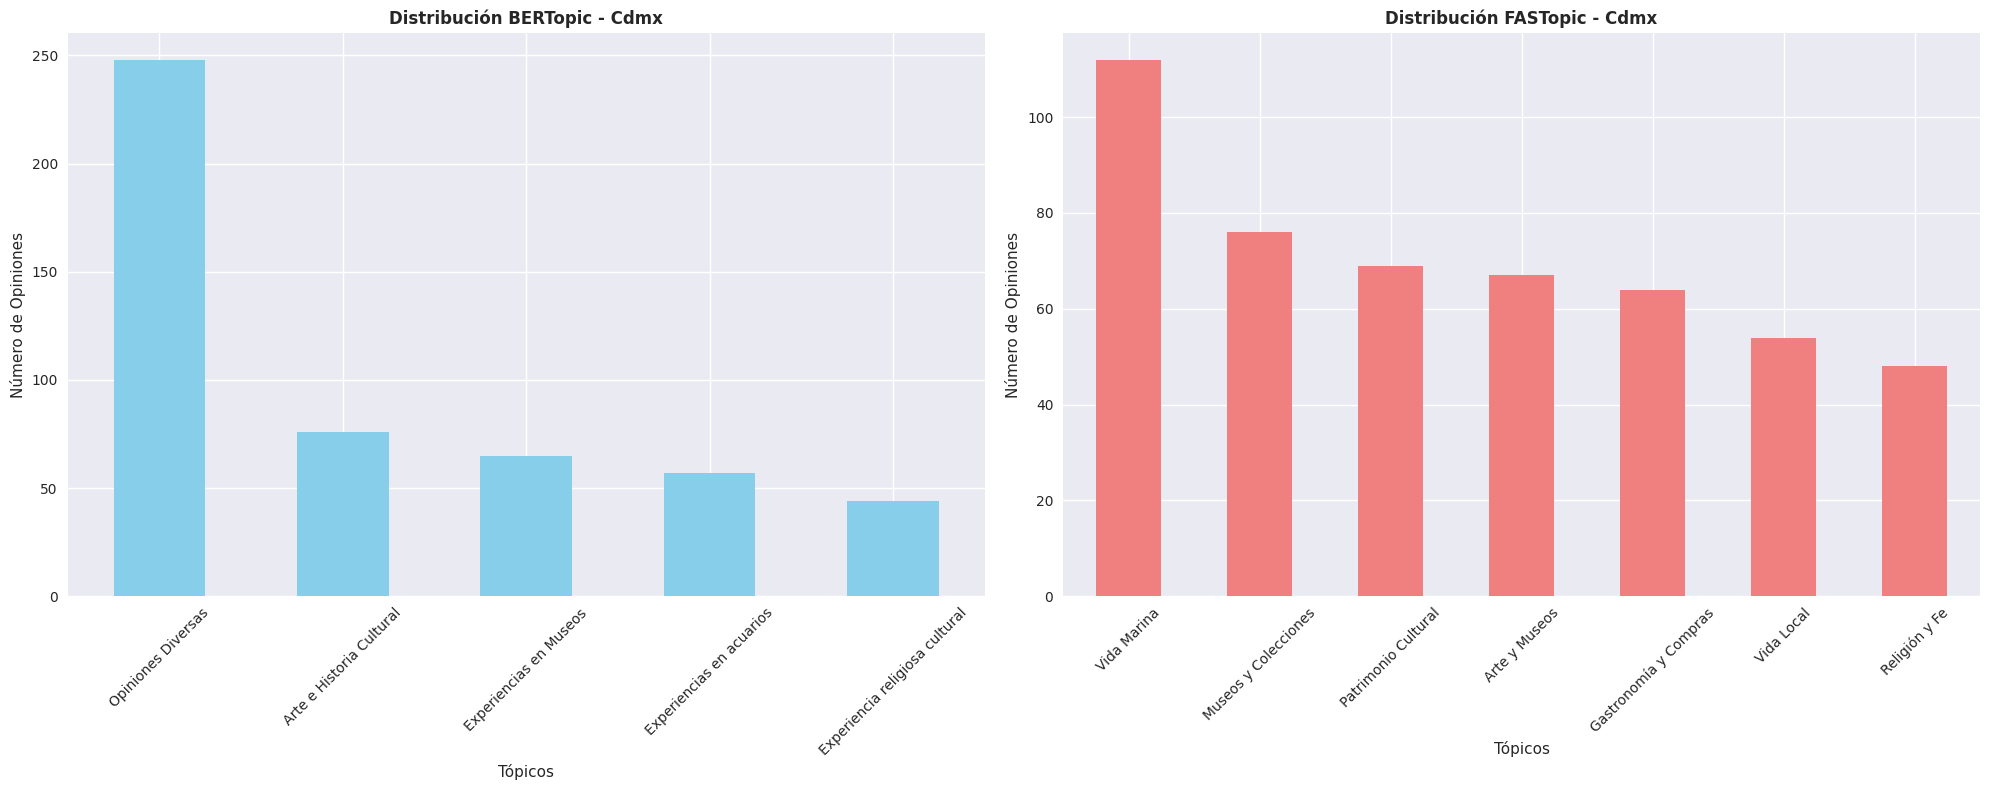


📈 TOP 5 TÓPICOS POR MÉTODO:

🔵 BERTopic:
   1. Opiniones Diversas: 248 (50.6%)
   2. Arte e Historia Cultural: 76 (15.5%)
   3. Experiencias en Museos: 65 (13.3%)
   4. Experiencias en acuarios: 57 (11.6%)
   5. Experiencia religiosa cultural: 44 (9.0%)

🔴 FASTopic:
   1. Vida Marina: 112 (22.9%)
   2. Museos y Colecciones: 76 (15.5%)
   3. Patrimonio Cultural: 69 (14.1%)
   4. Arte y Museos: 67 (13.7%)
   5. Gastronomía y Compras: 64 (13.1%)

💡 OBSERVACIONES:
   • FASTopic identificó 7 tópicos vs 5 de BERTopic
   • FASTopic muestra mayor granularidad en la segmentación
   • Tiempo FASTopic: 35.10s (más rápido que BERTopic)

📊 RESUMEN ACTUAL FASTopic:
   Total tópicos identificados: 7
   Tópicos en datos actuales: 7
   Documentos procesados: 490


In [17]:
# ===== COMPARACIÓN CON BERTOPIC =====

if 'TopicoConBERTopic' in df.columns:
    print(f"🔄 COMPARACIÓN FASTopic vs BERTopic en {CIUDAD_ANALIZAR}")
    print("=" * 60)
    
    # Usar datos actuales procesados en lugar de df_ciudad que puede tener datos previos
    df_comparacion = df_con_topicos[
        df_con_topicos.index.isin(df_ciudad[df_ciudad['TopicoConBERTopic'].notna()].index)
    ].copy()
    
    # Agregar datos de BERTopic al dataframe de comparación
    bertopic_data = df_ciudad[df_ciudad['TopicoConBERTopic'].notna()]['TopicoConBERTopic']
    df_comparacion = df_comparacion[df_comparacion.index.isin(bertopic_data.index)].copy()
    df_comparacion['TopicoConBERTopic'] = bertopic_data
    
    if len(df_comparacion) > 0:
        print(f"📊 Opiniones con ambos análisis: {len(df_comparacion)}")
        
        # Comparar número de tópicos únicos usando datos actuales
        topicos_bertopic = df_comparacion['TopicoConBERTopic'].nunique()
        topicos_fastopic = df_comparacion['Topico_Nombre'].nunique()  # Usar datos actuales
        
        print(f"\n🎯 NÚMERO DE TÓPICOS:")
        print(f"   BERTopic: {topicos_bertopic}")
        print(f"   FASTopic: {topicos_fastopic}")
        
        # Mostrar distribuciones lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # BERTopic
        bertopic_counts = df_comparacion['TopicoConBERTopic'].value_counts().head(10)
        bertopic_counts.plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title(f'Distribución BERTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[0].set_xlabel('Tópicos')
        axes[0].set_ylabel('Número de Opiniones')
        axes[0].tick_params(axis='x', rotation=45)
        
        # FASTopic - usar datos actuales
        fastopic_counts = df_comparacion['Topico_Nombre'].value_counts().head(10)
        fastopic_counts.plot(kind='bar', ax=axes[1], color='lightcoral')
        axes[1].set_title(f'Distribución FASTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[1].set_xlabel('Tópicos')
        axes[1].set_ylabel('Número de Opiniones')
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Análisis de concordancia (tópicos más frecuentes)
        print(f"\n📈 TOP 5 TÓPICOS POR MÉTODO:")
        print(f"\n🔵 BERTopic:")
        for i, (topico, count) in enumerate(bertopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
        
        print(f"\n🔴 FASTopic:")
        for i, (topico, count) in enumerate(fastopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
            
        print(f"\n💡 OBSERVACIONES:")
        print(f"   • FASTopic identificó {topicos_fastopic} tópicos vs {topicos_bertopic} de BERTopic")
        if topicos_fastopic > topicos_bertopic:
            print(f"   • FASTopic muestra mayor granularidad en la segmentación")
        elif topicos_fastopic < topicos_bertopic:
            print(f"   • FASTopic agrupa conceptos de manera más generalizada")
        else:
            print(f"   • Ambos métodos identificaron el mismo número de tópicos")
            
        print(f"   • Tiempo FASTopic: {tiempo_entrenamiento:.2f}s (más rápido que BERTopic)")
        
        # Mostrar resumen de datos actuales de FASTopic
        print(f"\n📊 RESUMEN ACTUAL FASTopic:")
        print(f"   Total tópicos identificados: {len(topic_info)}")
        print(f"   Tópicos en datos actuales: {df_con_topicos['Topico_Nombre'].nunique()}")
        print(f"   Documentos procesados: {len(df_con_topicos)}")
        
    else:
        print(f"⚠️ No hay opiniones de {CIUDAD_ANALIZAR} con ambos análisis completados")
        print(f"   BERTopic disponible: {df_ciudad['TopicoConBERTopic'].notna().sum()} opiniones")
        print(f"   FASTopic actual: {len(df_con_topicos)} opiniones")
else:
    print(f"ℹ️ No hay análisis previo de BERTopic para comparar")
    print(f"   Ejecuta el notebook 07-modelado-de-topicos-con-bertopic.ipynb primero")
    

In [18]:
generar_reporte_fastopic(
    topic_info, 
    len(df_con_topicos), 
    CIUDAD_ANALIZAR, 
    tiempo_entrenamiento
)

df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

📋 REPORTE COMPLETO - ANÁLISIS CON FASTOPIC
🎯 ANÁLISIS COMPLETADO:
   📍 Ciudad: Cdmx
   📄 Documentos analizados: 490
   🏷️ Tópicos identificados: 7
   ⏱️ Tiempo de entrenamiento: 35.10 segundos

📊 ESTADÍSTICAS DE TÓPICOS:
   🎯 Tópico más relevante: Vida Marina
   📈 Peso máximo: 98.221
   📉 Peso mínimo: 58.893
   📊 Peso promedio: 70.000

🏆 TOP 5 TÓPICOS POR RELEVANCIA:
   1. Vida Marina
      📊 Peso: 98.221 | 📄 Documentos: 201
      🔑 Palabras clave: animal, acu, grupo, cuidado, actividad, servicio, ...
   2. Patrimonio Cultural
      📊 Peso: 71.073 | 📄 Documentos: 210
      🔑 Palabras clave: castillo, templo, catedral, ruina, chap, palacio, ...
   3. Gastronomía y Compras
      📊 Peso: 67.223 | 📄 Documentos: 200
      🔑 Palabras clave: restaurante, tienda, calle, mercado, plaza, comida...
   4. Vida Local
      📊 Peso: 65.855 | 📄 Documentos: 248
      🔑 Palabras clave: fri, casa, vida, cultura, lugar, tour, guia, recom...
   5. Arte y Museos
      📊 Peso: 65.040 | 📄 Documentos: 208
    

In [19]:
# ===== EVALUACIÓN DE MÉTRICAS FASTOPIC =====

print(f"🔬 Evaluando modelo FASTopic para {CIUDAD_ANALIZAR}...")

topics_words_fastopic = extraer_palabras_fastopic(top_words, words_per_topic=10)
metricas_fastopic = evaluar_modelo_topicos(texts, topics_words_fastopic, f"FASTopic - {CIUDAD_ANALIZAR}")

mostrar_metricas(metricas_fastopic)

🔬 Evaluando modelo FASTopic para Cdmx...
📊 Evaluación FASTopic - Cdmx:
   🎯 Tópicos: 7
   📈 Coherencia CV: 0.4171
   🔄 Diversidad: 1.0000
📊 Evaluación FASTopic - Cdmx:
   🎯 Tópicos: 7
   📈 Coherencia CV: 0.4171
   🔄 Diversidad: 1.0000
